In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Data shape: (30, 3)
Time range: 1845.0 - 1874.0
Normalized time range: 0.000 - 1.000


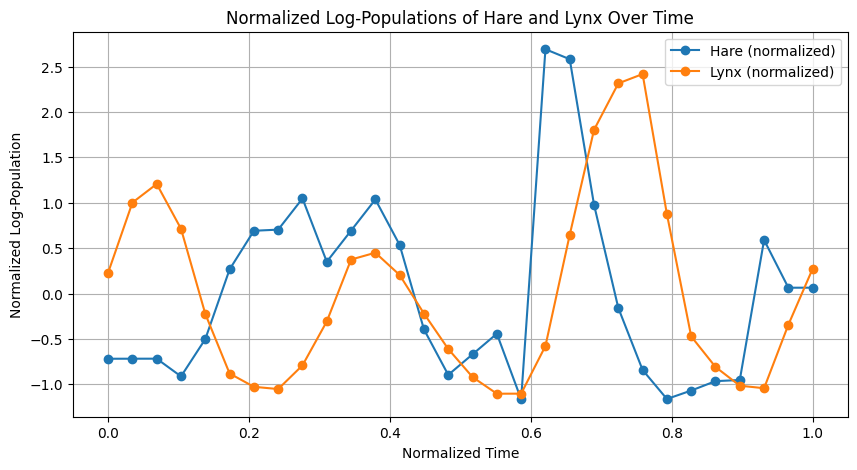

In [2]:
# =====================================================================
# 1. LOAD AND PREPROCESS DATA
# =====================================================================

# Load the Lynx-Hare data
lh_data = jnp.load("LH_data.npy")

# Extract time points and populations
t_raw = lh_data[:, 0]  # Years (1845-1874)
hare_raw = lh_data[:, 1]  # Hare population
lynx_raw = lh_data[:, 2]  # Lynx population

# Normalize time to [0, 1] for numerical stability
t_min, t_max = jnp.min(t_raw), jnp.max(t_raw)
t_normalized = (t_raw - t_min) / (t_max - t_min)

# Log-transform populations (predator-prey dynamics work better in log space)
# Adding small constant to avoid log(0)
# hare_log = jnp.log(hare_raw + 1e-3)
# lynx_log = jnp.log(lynx_raw + 1e-3)

# Standardize log-populations
hare_mean, hare_std = jnp.mean(hare_raw), jnp.std(hare_raw)
lynx_mean, lynx_std = jnp.mean(lynx_raw), jnp.std(lynx_raw)

hare_normalized = (hare_raw - hare_mean) / hare_std
lynx_normalized = (lynx_raw - lynx_mean) / lynx_std

# Stack into a (n, 2) array for ODE
y_true = jnp.stack([hare_normalized, lynx_normalized], axis=1)

# Store normalization parameters for later inverse transformation
norm_params = {
    't_min': t_min,
    't_max': t_max,
    'hare_mean': hare_mean,
    'hare_std': hare_std,
    'lynx_mean': lynx_mean,
    'lynx_std': lynx_std
}

print(f"Data shape: {lh_data.shape}")
print(f"Time range: {t_raw[0]:.1f} - {t_raw[-1]:.1f}")
print(f"Normalized time range: {t_normalized[0]:.3f} - {t_normalized[-1]:.3f}")

# plot normalized
plt.figure(figsize=(10, 5))
plt.plot(t_normalized, hare_normalized, label='Hare (normalized)', marker='o')
plt.plot(t_normalized, lynx_normalized, label='Lynx (normalized)', marker='o')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Log-Population')
plt.title('Normalized Log-Populations of Hare and Lynx Over Time')
plt.legend()
plt.grid()
plt.show()

In [3]:
# =====================================================================
# 2. DEFINE NEURAL ODE MODEL
# =====================================================================

class NeuralODE(eqx.Module):
    # Neural ODE model with learnable initial conditions
    mlp: eqx.nn.MLP
    y0_learnable: jnp.ndarray  # Learnable initial state
    
    def __init__(self, key):
        key1, key2 = jax.random.split(key)
        # MLP takes [hare, lynx, time] and outputs [d_hare/dt, d_lynx/dt]
        self.mlp = eqx.nn.MLP(
            in_size=3,  # 2 populations + time
            out_size=2,  # derivatives of both populations
            width_size=256,
            depth=2,
            activation=jax.nn.tanh,
            key=key1
        )
        # Initialize learnable y0 close to the actual first observation
        self.y0_learnable = jax.random.normal(key2, (2,)) * 0.1 + y_true[0]
    
    def __call__(self, t, y):
        # Compute dy/dt given current state y and time t"""
        # Concatenate state and time as input to MLP
        inp = jnp.concatenate([y, jnp.array([t])])
        return self.mlp(inp)

# Initialize model
key = jax.random.PRNGKey(42)
model = NeuralODE(key)

In [4]:
# =====================================================================
# 3. DEFINE ODE SOLVER AND LOSS FUNCTION
# =====================================================================

@eqx.filter_jit
def solve_ode(model, ts):
    # Solve the Neural ODE over given time points
    def vector_field(t, y, args):
        return args(t, y)
    
    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Tsit5()
    
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=ts[0],
        t1=ts[-1],
        dt0=1e-2,
        y0=model.y0_learnable,  # Use learnable initial condition
        saveat=diffrax.SaveAt(ts=ts),
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-7),
        max_steps=100_000,
        args=model,
        adjoint=diffrax.RecursiveCheckpointAdjoint(),
    )
    return sol.ys

@eqx.filter_value_and_grad
def loss_fn(model, y_true, ts):
    # Compute MSE loss between predicted and true trajectories
    y_pred = solve_ode(model, ts)
    return jnp.mean((y_pred - y_true) ** 2)

In [5]:
# =====================================================================
# 4. TRAINING SETUP
# =====================================================================

# Optimizer with learning rate schedule
# schedule = optax.exponential_decay(
#     init_value=1e-3,
#     transition_steps=1000,
#     decay_rate=0.95
# )
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def update(model, opt_state, y_true, ts):
    # Single training step
    loss, grads = loss_fn(model, y_true, ts)
    updates, opt_state = optimizer.update(
        grads,
        opt_state,
        params=eqx.filter(model, eqx.is_inexact_array)
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [6]:
# =====================================================================
# 5. TRAIN THE MODEL
# =====================================================================

loss_history = []
n_epochs = 10_000

print("\nTraining Neural ODE...")
for step in tqdm(range(n_epochs)):
    model, opt_state, loss = update(model, opt_state, y_true, t_normalized)
    loss_history.append(float(loss))
    
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_epochs}, Loss: {loss:.6f}")


Training Neural ODE...


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 500/10000, Loss: 0.612751
Step 1000/10000, Loss: 0.511815
Step 1500/10000, Loss: 0.461299
Step 2000/10000, Loss: 0.432213
Step 2500/10000, Loss: 0.395659
Step 3000/10000, Loss: 0.401318
Step 3500/10000, Loss: 0.335848
Step 4000/10000, Loss: 0.283902
Step 4500/10000, Loss: 0.241055
Step 5000/10000, Loss: 0.202683
Step 5500/10000, Loss: 0.180526
Step 6000/10000, Loss: 0.163875
Step 6500/10000, Loss: 0.148686
Step 7000/10000, Loss: 0.136101
Step 7500/10000, Loss: 0.121468
Step 8000/10000, Loss: 0.109012
Step 8500/10000, Loss: 0.096484
Step 9000/10000, Loss: 0.084903
Step 9500/10000, Loss: 0.074817
Step 10000/10000, Loss: 0.067704


In [7]:
# =====================================================================
# 6. FORECAST FUTURE POPULATIONS (20 YEARS AHEAD)
# =====================================================================

# Create time points for forecast: 1845-1894 (50 years total)
t_forecast_raw = jnp.linspace(t_min, t_min + 49, 50)  # 1845 to 1894
t_forecast_normalized = (t_forecast_raw - t_min) / (t_max - t_min)

# Solve ODE for full time range
y_forecast_normalized = solve_ode(model, t_forecast_normalized)

# Inverse transform: denormalize and exp to get actual populations
hare_forecast = y_forecast_normalized[:, 0] * hare_std + hare_mean
lynx_forecast = y_forecast_normalized[:, 1] * lynx_std + lynx_mean

# hare_forecast = jnp.exp(hare_forecast_log) - 1e-3
# lynx_forecast = jnp.exp(lynx_forecast_log) - 1e-3

# Stack predictions into (50, 2) array
predictions = jnp.stack([hare_forecast, lynx_forecast], axis=1)

# Save predictions
jnp.save("lh_predictions.npy", predictions)
print(f"\nPredictions saved to 'lh_predictions.npy'")
print(f"Shape: {predictions.shape}")


Predictions saved to 'lh_predictions.npy'
Shape: (50, 2)


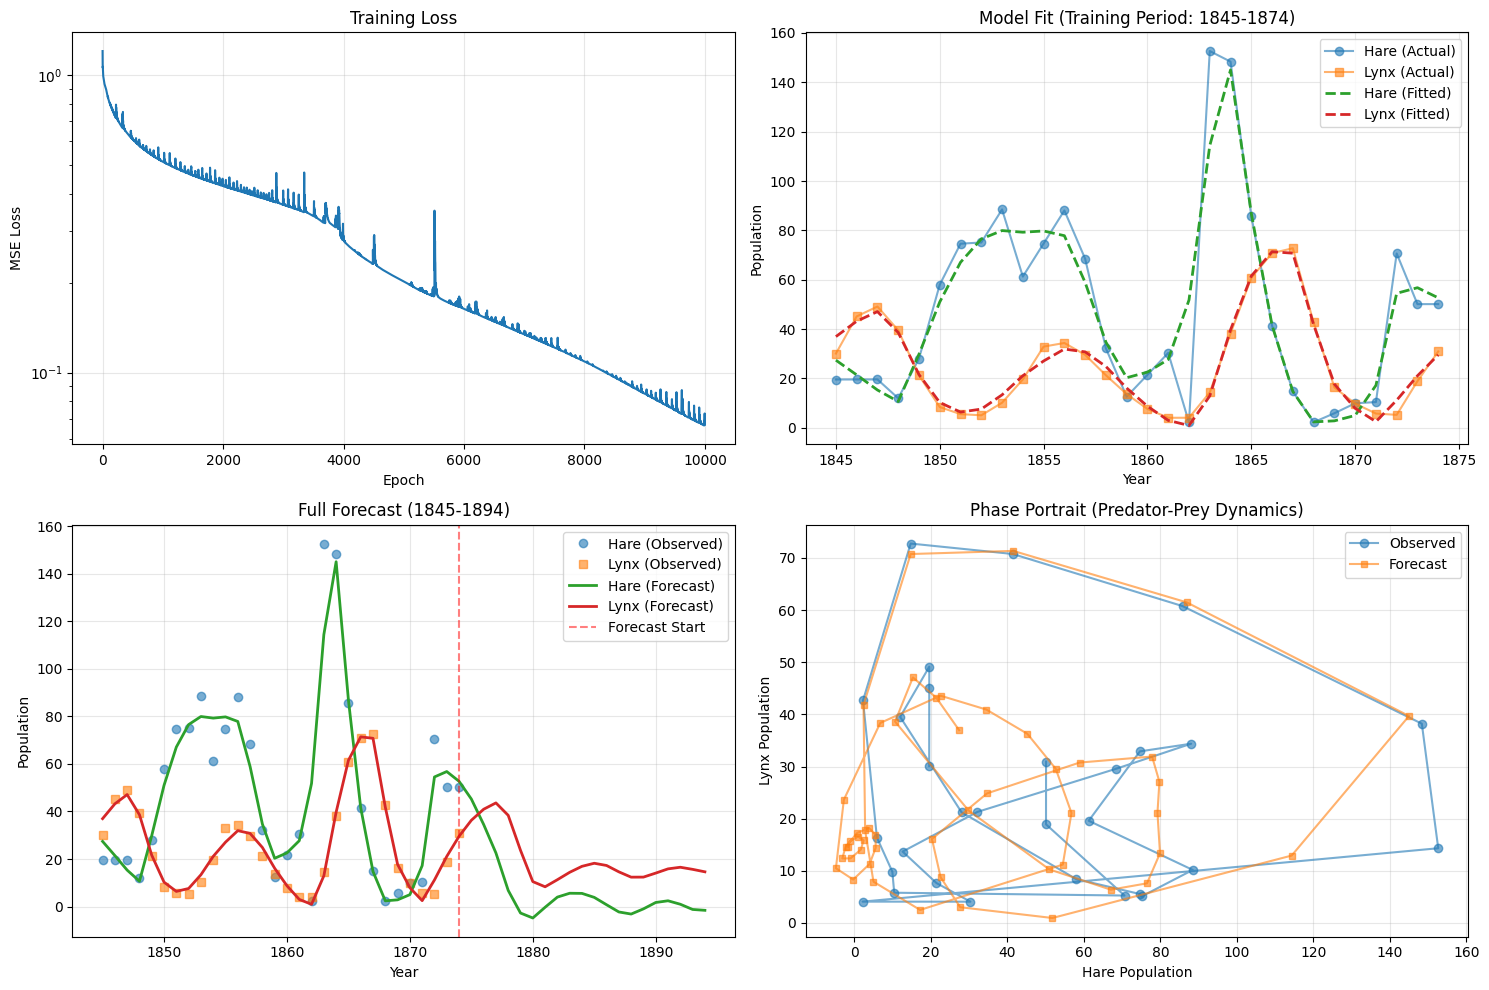


SUMMARY
Final training loss: 0.067704

Forecast period: 1866-1894
Hare forecast range: -4.8 - 45.2
Lynx forecast range: 8.3 - 43.6


In [8]:
# =====================================================================
# 7. VISUALIZATION
# =====================================================================

# Get fitted values on training data
y_fitted_normalized = solve_ode(model, t_normalized)
hare_fitted = y_fitted_normalized[:, 0] * hare_std + hare_mean
lynx_fitted = y_fitted_normalized[:, 1] * lynx_std + lynx_mean
# hare_fitted = jnp.exp(hare_fitted_log) - 1e-3
# lynx_fitted = jnp.exp(lynx_fitted_log) - 1e-3

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss
axes[0, 0].plot(loss_history)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Fitted vs Actual (Training Period)
axes[0, 1].plot(t_raw, hare_raw, 'o-', label='Hare (Actual)', alpha=0.6)
axes[0, 1].plot(t_raw, lynx_raw, 's-', label='Lynx (Actual)', alpha=0.6)
axes[0, 1].plot(t_raw, hare_fitted, '--', label='Hare (Fitted)', linewidth=2)
axes[0, 1].plot(t_raw, lynx_fitted, '--', label='Lynx (Fitted)', linewidth=2)
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Population')
axes[0, 1].set_title('Model Fit (Training Period: 1845-1874)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Full Forecast (1845-1894)
axes[1, 0].plot(t_raw, hare_raw, 'o', label='Hare (Observed)', alpha=0.6, markersize=6)
axes[1, 0].plot(t_raw, lynx_raw, 's', label='Lynx (Observed)', alpha=0.6, markersize=6)
axes[1, 0].plot(t_forecast_raw, hare_forecast, '-', label='Hare (Forecast)', linewidth=2)
axes[1, 0].plot(t_forecast_raw, lynx_forecast, '-', label='Lynx (Forecast)', linewidth=2)
axes[1, 0].axvline(x=t_raw[-1], color='red', linestyle='--', alpha=0.5, label='Forecast Start')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Population')
axes[1, 0].set_title('Full Forecast (1845-1894)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Phase Portrait
axes[1, 1].plot(hare_raw, lynx_raw, 'o-', label='Observed', alpha=0.6, markersize=6)
axes[1, 1].plot(hare_forecast, lynx_forecast, 's-', label='Forecast', alpha=0.6, markersize=4)
axes[1, 1].set_xlabel('Hare Population')
axes[1, 1].set_ylabel('Lynx Population')
axes[1, 1].set_title('Phase Portrait (Predator-Prey Dynamics)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lh_neural_ode_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final training loss: {loss_history[-1]:.6f}")
print(f"\nForecast period: {t_forecast_raw[-29]:.0f}-{t_forecast_raw[-1]:.0f}")
print(f"Hare forecast range: {jnp.min(hare_forecast[-20:]):.1f} - {jnp.max(hare_forecast[-20:]):.1f}")
print(f"Lynx forecast range: {jnp.min(lynx_forecast[-20:]):.1f} - {jnp.max(lynx_forecast[-20:]):.1f}")
print("="*60)